<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc">
  <ul class="toc-item">
    <li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span></li>
    <li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span>
      <ul class="toc-item">
        <li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li>
        <li><span><a href="#Logistic-Regression-with-Additional-Features" data-toc-modified-id="Logistic-Regression-with-Additional-Features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Logistic Regression with Additional Features</a></span></li>
        <li><span><a href="#BERT" data-toc-modified-id="BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT</a></span></li>
        <li><span><a href="#Evaluating-the-Best-Model-on-the-Test-Set" data-toc-modified-id="Evaluating-the-Best-Model-on-the-Test-Set-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Evaluating the Best Model on the Test Set</a></span></li>
      </ul>
    </li>
    <li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Conclusions</a></span></li>
    <li><span><a href="#Checklist" data-toc-modified-id="Checklist-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checklist</a></span></li>
  </ul>
</div>


# Wikishop Project with BERT

The online store “Wikishop” is launching a new service. Now users can edit and supplement product descriptions, like in wiki communities. In other words, customers suggest edits and comment on changes made by others. The store needs a tool that will detect toxic comments and send them for moderation.

Train a model to classify comments as positive or negative. You have a dataset with labels indicating the toxicity of the edits.

Build a model with an F1 quality metric score of at least 0.75.

**Dataset Description**

The data is in the file toxic_comments.csv. The text column contains the comment text, and the toxic column is the target label.

## Preparation


In [ ]:
import numpy as np
import pandas as pd
import os


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

from sklearn.pipeline import Pipeline, FeatureUnion

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from datetime import datetime
import re
import string
import itertools
import contractions

import gensim
from gensim.test.utils import datapath
from gensim.corpora import Dictionary
from gensim.models.doc2vec import TaggedDocument

from scipy.sparse import hstack, csr_matrix

import torch
import transformers
from tqdm import notebook
from transformers import BertTokenizer, BertConfig, BertModel

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import gc
import sys


print('All libraries are downloaded')

All libraries are downloaded


In [ ]:
# Check if the file exists
if os.path.exists('toxic_comments.csv'):
    data = pd.read_csv('toxic_comments.csv')
elif os.path.exists('datasets/toxic_comments.csv'):
    data = pd.read_csv('datasets/toxic_comments.csv')
else:
    print("❌ File not found. Make sure it is located in the current directory or inside the 'datasets' folder.")

# Display the first few rows
pd.set_option('display.max_colwidth', None)
if 'data' in locals():
    display(data.head())

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [ ]:
print("Number of messages:", len(data))


Number of messages: 159292


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
# Combine all tweets into a single string to check the length of the final text
full_text = " ".join(list(data.text.apply(str)))
print("Text length:", len(full_text), "characters")


Text length: 62871166 characters


In [ ]:
# Summary statistics for text data
data.describe(include=object)


,text
count,159292
unique,159292
top,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"
freq,1


In [ ]:
# Count unique characters

counter = Counter(full_text)
data_symbols = pd.DataFrame.from_dict(counter, orient='index').reset_index()
data_symbols.columns = ['symbol', 'count']
data_symbols['unicode'] = data_symbols.symbol.apply(ord)

print("Unique characters:", len(data_symbols))

Unique characters: 2335


In [ ]:
data_symbols

,symbol,count,unicode
0,E,122767,69
1,x,90081,120
2,p,964791,112
3,l,1925660,108
4,a,3778552,97
...,...,...,...
2330,名,1,21517
2331,☤,1,9764
2332,⁽,1,8317
2333,⁾,1,8318


In [ ]:
 # Remove extra whitespace
def replace_whitespace(text):
    return re.sub(r'\s+', ' ', text)


In [ ]:
print(f"Start cleaning at {datetime.now()}")

data['text'] = data.text.apply(replace_whitespace)
print(f"End cleaning at {datetime.now()}")

Start cleaning at 2025-04-06 20:09:13.550635
End cleaning at 2025-04-06 20:09:16.127078


In [ ]:
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,""" More I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know. There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [ ]:
def get_symbol_counter(data, column_name):
    full_text = " ".join(list(data[column_name].apply(str)))
    counter = Counter(full_text)
    return pd.DataFrame.from_dict(counter, orient='index').reset_index()

data_symbols_cleaned = get_symbol_counter(data, 'text')
data_symbols_cleaned.columns = ['symbol', 'count']
data_symbols_cleaned.sort_values(by='count', ascending=False, inplace=True)
data_symbols_cleaned.head()

,symbol,count
9,,10706581
13,e,5627184
6,t,4284017
4,a,3778552
8,o,3729522


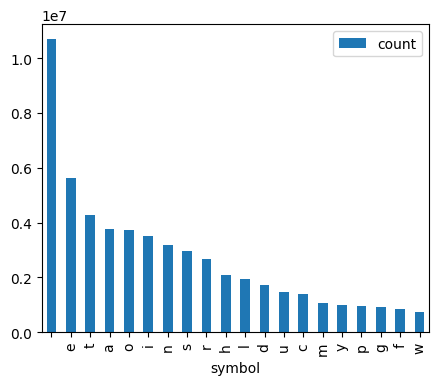

In [ ]:
data_symbols_cleaned.head(20).plot.bar(x='symbol', y='count', figsize=(5, 4));

/Users/eugenia/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32526 (\N{CJK UNIFIED IDEOGRAPH-7F0E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eugenia/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eugenia/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eugenia/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eugenia/Library/Python/3.9/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/eugenia/Libr

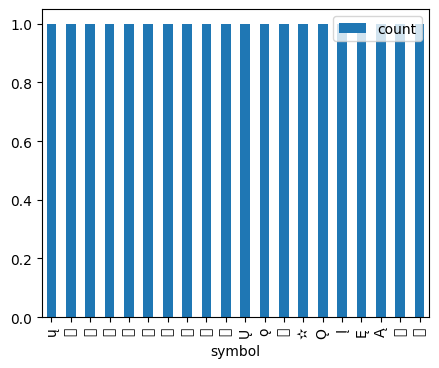

In [ ]:
data_symbols_cleaned.tail(20).plot.bar(x='symbol', y='count', figsize=(5, 4));

In [ ]:
data_symbols['unicode'] = data_symbols.symbol.apply(ord)
over_127 = data_symbols[data_symbols.unicode > 127]

print("Characters outside the basic Latin alphabet:", len(over_127))
print("Latin characters used:", len(data_symbols) - len(over_127))

Characters outside the basic Latin alphabet: 2238
Latin characters used: 97


In [ ]:
# Combine standard punctuation and non-Latin characters
bad_chars = string.punctuation + "".join(list(over_127.symbol))
print("Non-Latin characters:", bad_chars)

# Create a translation table to remove those characters
translation_table = str.maketrans(dict.fromkeys(bad_chars, ""))
print(translation_table)

Non-Latin characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ·•—“‘’”–「」¤¢സംവാദമോ്കെടരʍɐ¡¿†‡↔↑↓¶½⅓⅔¼¾⅛⅜⅝⅞∞«»₳฿₵₡₢₫₯€₠₣ƒ₴₭₤ℳ₥₦№₧₰£៛₨₪৳₮₩¥♠♣♥♦²³ÁáĆćÉéÍíĹĺŃńÓóŔŕŚśÚúÝýŹźÀàÈèÌìÒòÙùÂâĈĉÊêĜĝĤĥÎîĴĵÔôŜŝÛûŴŵŶŷÄäËëÏïÖöÜüŸÿßÃãẼẽĨĩÑñÕõŨũỸỹÇçĢģĶķĻļŅņŖŗŞşŢţĐđŮůǍǎČčĎďĚěǏǐĽľŇňǑǒŘřŠšŤťǓǔŽžĀāĒēĪīŌōŪūȲȳǢǣǖǘǚǜĂăĔĕĞğĬĭŎŏŬŭĊċĖėĠġİıŻżĄąĘęĮįǪǫŲųḌḍḤḥḶḷḸḹṂṃṆṇṚṛṜṝṢṣṬṭŁłŐőŰűĿŀĦħÐðÞþŒœÆæØøÅåƏəΆάΈέΉήΊίΌόΎύΏώΑαΒβΓγΔδΕεΖζΗηΘθΙιΚκΛλΜμΝνΞξΟοΠπΡρΣσςΤτΥυΦφΧχΨψΩωАаБбВвГгҐґЃѓДдЂђЕеЁёЄєЖжЗзЅѕИиІіЇїЙйЈјКкЌќЛлЉљМмНнЊњОоПпРрСсТтЋћУуЎўФфХхЦцЧчЏџШшЩщЪъЫыЬьЭэЮюЯя̪ʈɖɟɡɢʡʔɸʃʒɕʑʂʐʝɣʁʕʜʢɦɱɳɲŋɴʋɹɻɰʙʀɾɽɫɬɮɺɭʎʟɥɧɓɗʄɠʛʘǀǃǂǁɨʉɯɪʏʊɘɵɤɚɛɜɝɞʌɔɶɑɒʰʷʲˠˤⁿˡˈˌːˑ−→™☎☓✰´♫§⋅☼連絡見学迷惑🗽レンジャー竜龙御法度└┐¨יגוּמִצְרַםָלדאֶתעֲנהבפֻח≈ἰ©♪®►内ǧɩȋ琉⇔¦⇒✉☿グ☥‎…°☏˜☺​❤☮☯😜牛岩ترجمةթարգմնույঅনুবাদ翻译თარგმნიઅનુવાદअनुवाद訳ಅನುವಾದបក្រែ번역ການແປພສभषंतरकणेهமொழிபெயர்ுఅనువాదการแปลịזשׁ״ך曹操‖Ⓣ←🍁ʞʇ✍≡√⊕⊗⁠聖や 福原信三路草日本写真家事典😅⁄（） ầㄏㄨㄤㄉㄧסӧṁ🍌ẓ会話हि्ीংলϾ✐♬♩☆龍≤♂ ⁂≠ ★步驚心電視劇∂ᛏ╟─╢雲水∇∆〈ῦ͡飞天号航服सघŦ×ț✄是吗？☻คุ―ῶἐῃᾳὶὧ�豆田みせよ松浦靜山うの『甲子夜』にえる川柳。おそらくは人知ず江戸後期平藩主・静が詠んだ句鳴かぬなしてほとぎすựứ﻿́߷♀۝҈♨ውይት♑ｗ．ＡｎｏＴａｌｋｃｍ☀୯̮د੭✆☇☄下さい✎ק¸ºحوياأخف

We can see that the tweets are written in different languages, and not all of them are European, where we can determine sentiment based on context.

In [ ]:
# Calculate the length of the original (uncleaned) text
data['dirty_len'] = data.text.apply(len)
data.head()

print("Total length of the original text:", data.dirty_len.sum())

Total length of the original text: 62209334


In [ ]:
# Function to remove unwanted characters using the translation table
def translate_text(text):
    return text.translate(translation_table)

print(f"Start cleaning at {datetime.now()}")
data['text'] = data.text.apply(translate_text)
print(f"End cleaning at {datetime.now()}")

Start cleaning at 2025-04-06 20:11:48.408266
End cleaning at 2025-04-06 20:11:51.773817


In [ ]:
# Calculate length of text after removing non-Latin characters
data['clean_len'] = data.text.apply(len)
data.head()

print("Length of text after removing non-Latin characters:", data.clean_len.sum())
print("Characters removed:", data.dirty_len.sum() - data.clean_len.sum())

Length of text after removing non-Latin characters: 59622652
Characters removed: 2586682


In [ ]:
# Function to check for multiple consecutive whitespaces
def check_multiple_whitespaces(text):
    return re.search(r'\s{2,}', text) is not None

print("Extra whitespaces:", data.text.apply(check_multiple_whitespaces).sum())
print("Total rows:", len(data))

Extra whitespaces: 36766
Total rows: 159292


In [ ]:
# Function to remove multiple consecutive whitespaces
def remove_multiple_whitespaces(text):
    return re.sub(r'\s{2,}', ' ', text)

print(f"Start cleaning at {datetime.now()}")
data['text'] = data.text.apply(remove_multiple_whitespaces)
print(f"End cleaning at {datetime.now()}")

print("Extra whitespaces remaining:", data.text.apply(check_multiple_whitespaces).sum())

Start cleaning at 2025-04-06 20:12:55.826014
End cleaning at 2025-04-06 20:12:57.037746
Extra whitespaces remaining: 0


In [ ]:
print(data.head())

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                                                                                                                                     

In [ ]:
def split_text(text):
    return text.split()

In [ ]:
print(f"Start cleaning at {datetime.now()}")
data['words'] = data.text.apply(split_text)
print(f"End cleaning at {datetime.now()}")

# Check data types
data.dtypes


Start cleaning at 2025-04-06 20:14:37.312482
End cleaning at 2025-04-06 20:14:38.641124


Unnamed: 0     int64
text          object
toxic          int64
dirty_len      int64
clean_len      int64
words         object
dtype: object

In [ ]:
print(data.head())

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                                                                                                                                     

In [ ]:
data['word_count'] = data.words.apply(len)
print(data.head())

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                                                                                                                                     

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stop_words(words):
    return [word for word in words if word not in stop_words]

print(f"Start cleaning at {datetime.now()}")
data['words'] = data.words.apply(remove_stop_words)
print(f"End cleaning at {datetime.now()}")

data['word_count_cleaned'] = data.words.apply(len)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugenia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Start cleaning at 2025-04-06 20:14:51.644360
End cleaning at 2025-04-06 20:14:53.677783


,Unnamed: 0,text,toxic,dirty_len,clean_len,words,word_count,word_count_cleaned
0,0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827,0,264,254,"[Explanation, Why, edits, made, username, Hardcore, Metallica, Fan, reverted, They, werent, vandalisms, closure, GAs, I, voted, New, York, Dolls, FAC, And, please, dont, remove, template, talk, page, since, Im, retired, now892053827]",43,31
1,1,Daww He matches this background colour Im seemingly stuck with Thanks talk 2151 January 11 2016 UTC,0,111,99,"[Daww, He, matches, background, colour, Im, seemingly, stuck, Thanks, talk, 2151, January, 11, 2016, UTC]",17,15
2,2,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,0,233,227,"[Hey, man, Im, really, trying, edit, war, Its, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, He, seems, care, formatting, actual, info]",42,24
3,3,More I cant make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up Its listed in the relevant form eg WikipediaGoodarticlenominationsTransport,0,619,598,"[More, I, cant, make, real, suggestions, improvement, I, wondered, section, statistics, later, subsection, types, accidents, I, think, references, may, need, tidying, exact, format, ie, date, format, etc, I, later, noone, else, first, preferences, formatting, style, references, want, please, let, know, There, appears, backlog, articles, review, I, guess, may, delay, reviewer, turns, Its, listed, relevant, form, eg, WikipediaGoodarticlenominationsTransport]",109,57
4,4,You sir are my hero Any chance you remember what page thats on,0,67,62,"[You, sir, hero, Any, chance, remember, page, thats]",13,8


In [ ]:
print("Words removed:", data['word_count'].sum() - data['word_count_cleaned'].sum())
print("Words remaining:", data['word_count_cleaned'].sum())

Words removed: 4389329
Words remaining: 6136150


In [ ]:
nltk.data.path.append('/Users/eugenia/nltk_data')


In [ ]:
nltk.download('averaged_perceptron_tagger', download_dir='/Users/eugenia/nltk_data')
nltk.download('wordnet', download_dir='/Users/eugenia/nltk_data')
nltk.download('omw-1.4', download_dir='/Users/eugenia/nltk_data')
nltk.download('punkt', download_dir='/Users/eugenia/nltk_data')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/eugenia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/eugenia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/eugenia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/eugenia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng', download_dir='/Users/eugenia/nltk_data', force=True)
nltk.download('wordnet', download_dir='/Users/eugenia/nltk_data', force=True)
nltk.download('omw-1.4', download_dir='/Users/eugenia/nltk_data', force=True)
nltk.download('punkt', download_dir='/Users/eugenia/nltk_data', force=True)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/eugenia/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /Users/eugenia/nltk_data...
[nltk_data] Downloading package omw-1.4 to /Users/eugenia/nltk_data...
[nltk_data] Downloading package punkt to /Users/eugenia/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
print(nltk.data.path)
print(nltk.find('taggers/averaged_perceptron_tagger'))

['/Users/eugenia/nltk_data', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/nltk_data', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/share/nltk_data', '/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data', '/Users/eugenia/nltk_data']
/Users/eugenia/nltk_data/taggers/averaged_perceptron_tagger


In [ ]:

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_word_list(word_list):
    return [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in word_list]

def preprocess_text(text):
    if isinstance(text, list):

        words = [word.lower() for word in text if word.isalpha()]
    else:

        expanded_text = contractions.fix(text)
        words = nltk.word_tokenize(expanded_text)
        words = [word.lower() for word in words if word.isalpha()]


    lemmatized_words = lemmatize_word_list(words)

    return lemmatized_words

print(f"Start preprocessing at {datetime.now()}")

data['words_lemmatized'] = data['words'].apply(preprocess_text)
print(f"End preprocessing at {datetime.now()}")


print(data.head())

Start preprocessing at 2025-04-06 20:17:46.444512
End preprocessing at 2025-04-06 20:22:49.628601


,Unnamed: 0,text,toxic,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized
0,0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827,0,264,254,"[Explanation, Why, edits, made, username, Hardcore, Metallica, Fan, reverted, They, werent, vandalisms, closure, GAs, I, voted, New, York, Dolls, FAC, And, please, dont, remove, template, talk, page, since, Im, retired, now892053827]",43,31,"[explanation, why, edits, make, username, hardcore, metallica, fan, revert, they, werent, vandalism, closure, gas, i, vote, new, york, doll, fac, and, please, dont, remove, template, talk, page, since, im, retire]"
1,1,Daww He matches this background colour Im seemingly stuck with Thanks talk 2151 January 11 2016 UTC,0,111,99,"[Daww, He, matches, background, colour, Im, seemingly, stuck, Thanks, talk, 2151, January, 11, 2016, UTC]",17,15,"[daww, he, match, background, colour, im, seemingly, stuck, thanks, talk, january, utc]"
2,2,Hey man Im really not trying to edit war Its just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info,0,233,227,"[Hey, man, Im, really, trying, edit, war, Its, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, He, seems, care, formatting, actual, info]",42,24,"[hey, man, im, really, try, edit, war, it, guy, constantly, remove, relevant, information, talk, edits, instead, talk, page, he, seem, care, format, actual, info]"
3,3,More I cant make any real suggestions on improvement I wondered if the section statistics should be later on or a subsection of types of accidents I think the references may need tidying so that they are all in the exact same format ie date format etc I can do that later on if noone else does first if you have any preferences for formatting style on references or want to do it yourself please let me know There appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up Its listed in the relevant form eg WikipediaGoodarticlenominationsTransport,0,619,598,"[More, I, cant, make, real, suggestions, improvement, I, wondered, section, statistics, later, subsection, types, accidents, I, think, references, may, need, tidying, exact, format, ie, date, format, etc, I, later, noone, else, first, preferences, formatting, style, references, want, please, let, know, There, appears, backlog, articles, review, I, guess, may, delay, reviewer, turns, Its, listed, relevant, form, eg, WikipediaGoodarticlenominationsTransport]",109,57,"[more, i, cant, make, real, suggestion, improvement, i, wonder, section, statistic, later, subsection, type, accident, i, think, reference, may, need, tidy, exact, format, ie, date, format, etc, i, later, noone, else, first, preference, format, style, reference, want, please, let, know, there, appear, backlog, article, review, i, guess, may, delay, reviewer, turn, it, list, relevant, form, eg, wikipediagoodarticlenominationstransport]"
4,4,You sir are my hero Any chance you remember what page thats on,0,67,62,"[You, sir, hero, Any, chance, remember, page, thats]",13,8,"[you, sir, hero, any, chance, remember, page, thats]"


In [ ]:
# Flatten the list of tokenized words and count unique ones
all_words = list(itertools.chain.from_iterable(data.words))
print("Unique words:", len(set(all_words)))

# Flatten the list of lemmatized words and count unique lemmas
all_words_lemmatized = list(itertools.chain.from_iterable(data.words_lemmatized))
print("Unique lemmas:", len(set(all_words_lemmatized)))

Unique words: 292530
Unique lemmas: 197156


In [ ]:
def remove_digits(words):

    return [word for word in words if not word.isdigit()]

data.words_lemmatized = data.words_lemmatized.apply(remove_digits)
data["word_count_cleaned_no_digits"] = data.words_lemmatized.apply(len)
print(data.head())

   Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   text  \
0                                                                                                                                                                                                                                                                                                     

In [ ]:
# Function to remove words that contain any digits
def remove_words_with_digits(words):
    return [word for word in words if not any(char.isdigit() for char in word)]

# Apply the function to the lemmatized words
data.words_lemmatized = data.words_lemmatized.apply(remove_words_with_digits)
data["word_count_cleaned_no_digits"] = data.words_lemmatized.apply(len)

print("Number of tweets:", data.shape[0])
print("Words containing digits removed:", data.word_count_cleaned.sum() - data.word_count_cleaned_no_digits.sum())
print("Words remaining:", data.word_count_cleaned_no_digits.sum())

Number of tweets: 159292
Words containing digits removed: 149272
Words remaining: 5986878


In [ ]:
# Fit a TF-IDF vectorizer on the lemmatized words
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(data.words_lemmatized.apply(" ".join))

print("Unique words:", len(tfidf_vectorizer.vocabulary_))
list(tfidf_vectorizer.vocabulary_.items())[:20]  # Show first 20 vocabulary entries

Unique words: 197130


[('explanation', 55141),
 ('why', 187243),
 ('edits', 49530),
 ('make', 100610),
 ('username', 179991),
 ('hardcore', 69984),
 ('metallica', 105325),
 ('fan', 56348),
 ('revert', 141591),
 ('they', 169475),
 ('werent', 186396),
 ('vandalism', 181636),
 ('closure', 30992),
 ('gas', 63330),
 ('vote', 184092),
 ('new', 113804),
 ('york', 195467),
 ('doll', 46280),
 ('fac', 55669),
 ('and', 6634)]

In [ ]:
# Filter out sentences with length 0
filtered_sentences_with_indices = [(i, sentence) for i, sentence in enumerate(data.words_lemmatized.tolist()) if len(sentence) > 0]

# Separate indices and sentences
filtered_indices = [i for i, sentence in filtered_sentences_with_indices]
sentences = [sentence for i, sentence in filtered_sentences_with_indices]

# Check sentence stats after filtering
print("Number of tweets:", len(sentences))
print("Minimum sentence length:", min([len(sentence) for sentence in sentences]))
print("Maximum sentence length:", max([len(sentence) for sentence in sentences]))

# Train a Word2Vec model
w2v_model = gensim.models.Word2Vec(sentences=sentences)

Number of tweets: 159240
Minimum sentence length: 1
Maximum sentence length: 1383


In [ ]:
tagged_sentences = [gensim.models.doc2vec.TaggedDocument(sentence, [i]) for i, sentence in enumerate(sentences)]

In [ ]:
d2v_model = gensim.models.Doc2Vec(
    vector_size=100,     # Vector size (can be increased for better accuracy)
    min_count=2,         # Minimum frequency of a word to be considered
    epochs=40,           # Number of training epochs
    window=5,            # Context window size
    dm=1,                # Training algorithm: 1 — DM (Distributed Memory), 0 — DBOW
    workers=4            # Number of worker threads (based on CPU cores)
)

In [ ]:
d2v_model.build_vocab(tagged_sentences)
d2v_model.train(tagged_sentences, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
len(d2v_model.dv)

159240

In [ ]:
data['doc2vec'] = None
for idx, vector in zip(filtered_indices, d2v_model.dv):
    data.at[idx, 'doc2vec'] = vector
data.head(1)

,Unnamed: 0,text,toxic,dirty_len,clean_len,words,word_count,word_count_cleaned,words_lemmatized,word_count_cleaned_no_digits,doc2vec
0,0,Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827,0,264,254,"[Explanation, Why, edits, made, username, Hardcore, Metallica, Fan, reverted, They, werent, vandalisms, closure, GAs, I, voted, New, York, Dolls, FAC, And, please, dont, remove, template, talk, page, since, Im, retired, now892053827]",43,31,"[explanation, why, edits, make, username, hardcore, metallica, fan, revert, they, werent, vandalism, closure, gas, i, vote, new, york, doll, fac, and, please, dont, remove, template, talk, page, since, im, retire]",30,"[0.7724078, -0.57992125, 0.8794413, -0.6368764, 0.04623737, 0.8891005, -0.7507112, -0.12640095, -0.72199714, -0.5170304, -0.47949797, -0.5531771, 1.0865148, -0.6857148, -0.45067087, 0.03693739, -0.60690266, 1.3406551, 0.2872252, 0.5704712, 0.6701598, -0.68028796, -0.04721625, -0.21645397, 0.5169594, 1.4363616, 0.28938785, 0.090483464, -0.74543, -0.5547359, -1.0830312, 0.02477289, 0.44779804, -0.6095908, 1.2240577, -0.5812384, 0.26844993, -0.23541619, 0.43634868, 0.83296686, -0.0072973557, 0.30824625, 0.39660963, -0.5157454, 0.25193092, -0.4177024, 0.40938038, -0.06400628, -1.0700427, -0.0031530897, 0.44634005, -0.03465753, -0.64062834, 0.5929856, 0.85718524, 0.3736478, 1.4557589, 0.68422997, -0.47857183, 0.044323076, 0.3513946, 0.35632926, -0.32313076, 1.054487, -0.11945534, -0.5186988, 0.09026859, 0.11671696, -0.2081145, 0.4887674, 0.4255189, 0.3209769, -0.021053392, -0.03933725, -0.8414647, 0.22005473, 0.63537025, -0.27483526, 0.065028064, 0.28864884, 0.13348518, -0.121625416, -0.9521123, -0.39673048, -0.048140228, 0.24405734, 0.47653645, 0.3309957, -0.12987736, 0.21896254, 0.42556113, -0.1648871, -0.66343623, 0.799902, 0.1954294, 0.46313673, 0.14548507, 0.050330408, 0.1994809, 0.13774525]"


## Training

In [ ]:
%free -h

In [ ]:
%sync; echo 3 > /proc/sys/vm/drop_caches

In [ ]:
%free -h

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Unnamed: 0                    159292 non-null  int64 
 1   text                          159292 non-null  object
 2   toxic                         159292 non-null  int64 
 3   dirty_len                     159292 non-null  int64 
 4   clean_len                     159292 non-null  int64 
 5   words                         159292 non-null  object
 6   word_count                    159292 non-null  int64 
 7   word_count_cleaned            159292 non-null  int64 
 8   words_lemmatized              159292 non-null  object
 9   word_count_cleaned_no_digits  159292 non-null  int64 
 10  doc2vec                       159240 non-null  object
dtypes: int64(7), object(4)
memory usage: 13.4+ MB


In [ ]:
# Extract features and target variable
y = data['toxic']  # Use the 'toxic' column as the target variable

# Feature matrix - use text column for TF-IDF vectorization
X = data['text']  # Use the 'text' column as input features

print(X.head())

0                                                                                                                                                                                                                                                                                                                                                          Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They werent vandalisms just closure on some GAs after I voted at New York Dolls FAC And please dont remove the template from the talk page since Im retired now892053827
1                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: toxic, dtype: int64


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Datasets are ready')

Datasets are ready


In [ ]:
print(data.isnull().sum())

Unnamed: 0                       0
text                             0
toxic                            0
dirty_len                        0
clean_len                        0
words                            0
word_count                       0
word_count_cleaned               0
words_lemmatized                 0
word_count_cleaned_no_digits     0
doc2vec                         52
dtype: int64


In [ ]:
data_cleaned = data.dropna()

In [ ]:
data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 159240 entries, 0 to 159291
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Unnamed: 0                    159240 non-null  int64 
 1   text                          159240 non-null  object
 2   toxic                         159240 non-null  int64 
 3   dirty_len                     159240 non-null  int64 
 4   clean_len                     159240 non-null  int64 
 5   words                         159240 non-null  object
 6   word_count                    159240 non-null  int64 
 7   word_count_cleaned            159240 non-null  int64 
 8   words_lemmatized              159240 non-null  object
 9   word_count_cleaned_no_digits  159240 non-null  int64 
 10  doc2vec                       159240 non-null  object
dtypes: int64(7), object(4)
memory usage: 14.6+ MB


In [ ]:
y_cleaned = data_cleaned['toxic']

In [ ]:
print(y_cleaned.info())

<class 'pandas.core.series.Series'>
Index: 159240 entries, 0 to 159291
Series name: toxic
Non-Null Count   Dtype
--------------   -----
159240 non-null  int64
dtypes: int64(1)
memory usage: 2.4 MB
None


In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    data_cleaned, y_cleaned, test_size=0.2, random_state=42, stratify=y_cleaned
)

In [ ]:
# 2. Convert text into TF-IDF features
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on the training set
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_full['text'])

# Transform the test set using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test_full['text'])

# 3. Transform numerical features using FunctionTransformer
def numeric_transformer(X):
    return csr_matrix(X[['dirty_len', 'clean_len', 'word_count', 'word_count_cleaned', 'word_count_cleaned_no_digits']].values)

numeric_features = FunctionTransformer(numeric_transformer)

# Transform the training set
X_train_numeric = numeric_features.transform(X_train_full)

# Transform the test set
X_test_numeric = numeric_features.transform(X_test_full)

# 4. Convert Doc2Vec vectors into NumPy arrays, then to sparse matrix
def doc2vec_transformer(X):
    return csr_matrix(np.array([np.zeros(100) if vec is None else vec for vec in X['doc2vec']]))

doc2vec_features = FunctionTransformer(doc2vec_transformer)

# Transform the training set
X_train_doc2vec = doc2vec_features.transform(X_train_full)

# Transform the test set
X_test_doc2vec = doc2vec_features.transform(X_test_full)

# 5. Combine all features into a single matrix for the training set
X_train_combined = hstack([X_train_tfidf, X_train_numeric, X_train_doc2vec])

# Combine all features into a single matrix for the test set
X_test_combined = hstack([X_test_tfidf, X_test_numeric, X_test_doc2vec])

print(f"Training set shape: {X_train_combined.shape}")
print(f"Test set shape: {X_test_combined.shape}")


Training set shape: (127392, 213275)
Test set shape: (31848, 213275)


### Logistic Regression

In [ ]:
# 1. List of stop words
stop_words = list(stopwords.words('english'))

# 2. Create a pipeline that includes a TF-IDF vectorizer and a logistic regression model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words=stop_words,     # Use the list of stop words
        ngram_range=(1, 2),        # Use unigrams and bigrams
        min_df=5,                  # Ignore terms that appear in fewer than 5 documents
        max_df=0.9                 # Ignore terms that appear in more than 90% of documents
    )),
    ('model', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    ))
])

# 3. Hyperparameter tuning with GridSearchCV
param_grid = {
    'model__C': [1, 10, 20],                # Regularization strength for logistic regression
    'model__penalty': ['l1', 'l2'],         # L1 and L2 regularization
    'model__solver': ['liblinear']          # Solver that supports both L1 and L2
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1',        # Evaluation metric: F1-score
    n_jobs=-1,
    verbose=1
)

# 4. Train the model
grid_search.fit(X_train, y_train)

# 5. Save the best model to a variable
best_model_reg = grid_search.best_estimator_

# 6. Best model results
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best F1-score: 0.7653781905047358


The best F1-score on cross-validation is 0.76, which meets the task requirements. But let's also try logistic regression on the dataset with additional features.

In [ ]:
!free -h

In [ ]:
# Function to format the size of an object in a more readable way
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# Get all variables in the global scope
all_variables = {name: sys.getsizeof(value) for name, value in globals().items() if not name.startswith('_')}

# Sort variables by size in descending order
sorted_variables = sorted(all_variables.items(), key=lambda x: x[1], reverse=True)

# Print the sizes of the variables
for name, size in sorted_variables:
    print(f"{name}: {sizeof_fmt(size)}")

full_text: 239.8 MiB
data_cleaned: 216.2 MiB
data: 215.0 MiB
X_train_full: 173.0 MiB
X: 65.4 MiB
X_train: 53.3 MiB
all_words: 47.2 MiB
all_words_lemmatized: 47.2 MiB
X_test_full: 43.2 MiB
X_test: 13.3 MiB
y_cleaned: 2.4 MiB
y_train: 1.9 MiB
y_train_full: 1.9 MiB
filtered_sentences_with_indices: 1.2 MiB
filtered_indices: 1.2 MiB
sentences: 1.2 MiB
tagged_sentences: 1.2 MiB
y: 1.2 MiB
y_test: 497.8 KiB
y_test_full: 497.6 KiB
over_127: 236.0 KiB
data_symbols: 225.6 KiB
data_symbols_cleaned: 224.6 KiB
counter: 72.1 KiB
translation_table: 72.1 KiB
bad_chars: 8.9 KiB
TfidfVectorizer: 2.0 KiB
stop_words: 1.6 KiB
GridSearchCV: 1.4 KiB
LogisticRegression: 1.4 KiB
FunctionTransformer: 1.2 KiB
Dictionary: 1.2 KiB
WordNetLemmatizer: 1.0 KiB
Pipeline: 1.0 KiB
FeatureUnion: 1.0 KiB
Counter: 1.0 KiB
TaggedDocument: 1.0 KiB
BertTokenizer: 1.0 KiB
BertConfig: 1.0 KiB
BertModel: 1.0 KiB
csr_matrix: 896.0 B
In: 664.0 B
Out: 640.0 B
datetime: 408.0 B
param_grid: 232.0 B
open: 136.0 B
pos_tag: 136.0 B
cosi

In [ ]:
import gc

# Удаление ненужных переменных
del full_text
del all_words
del all_words_lemmatized
del filtered_sentences_with_indices
del filtered_indices
del sentences
del tagged_sentences
del over_127
del data_symbols
del data_symbols_cleaned
del translation_table
del bad_chars
del all_variables
del pos_tag
del replace_whitespace
del get_symbol_counter
del translate_text
del check_multiple_whitespaces
del remove_multiple_whitespaces
del split_text
del remove_stop_words
del get_wordnet_pos
del lemmatize_word_list
del preprocess_text
del remove_digits
del remove_words_with_digits

# Вызов сборщика мусора для очистки памяти
gc.collect()

29

In [ ]:
!free -h

### Logistic Regresion with Additional Features

I'll try using the features I created during the text preprocessing process.

In [ ]:
# Define logistic regression model
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [1, 10, 20],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=3
)

# Train the model
grid_search.fit(X_train_combined, y_train_full)

# Save the best model
best_model_reg_full = grid_search.best_estimator_

# Best model results
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .C=1, penalty=l2, solver=liblinear;, score=0.743 total time= 4.3min
[CV 3/5] END .C=1, penalty=l2, solver=liblinear;, score=0.757 total time= 6.1min
[CV 4/5] END .C=1, penalty=l2, solver=liblinear;, score=0.749 total time= 7.2min
[CV 2/5] END .C=1, penalty=l2, solver=liblinear;, score=0.739 total time= 8.4min
[CV 2/5] END C=10, penalty=l2, solver=liblinear;, score=0.771 total time= 8.8min
[CV 5/5] END .C=1, penalty=l2, solver=liblinear;, score=0.738 total time= 9.5min
[CV 3/5] END C=10, penalty=l2, solver=liblinear;, score=0.785 total time=11.7min
[CV 1/5] END C=10, penalty=l2, solver=liblinear;, score=0.782 total time=13.5min
[CV 4/5] END C=10, penalty=l2, solver=liblinear;, score=0.785 total time= 9.5min
[CV 1/5] END C=20, penalty=l2, solver=liblinear;, score=0.785 total time= 6.7min
[CV 2/5] END C=20, penalty=l2, solver=liblinear;, score=0.772 total time= 5.6min
[CV 5/5] END C=10, penalty=l2, solver=liblinear;,

The regression algorithm with additional features achieved an F1-score of 0.78 on cross-validation, which is better than without the features and meets the task requirements.

### BERT

In [ ]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('unitary/toxic-bert')

MAX_LEN = 512

# Tokenize the text, adding special tokens, truncating, and padding automatically
encoding = tokenizer(
    data['text'].tolist(),
    add_special_tokens=True,  # Add [CLS] and [SEP] tokens
    max_length=MAX_LEN,       # Maximum length for truncation
    truncation=True,          # Truncate sequences longer than MAX_LEN
    padding='longest',        # Pad sequences to the longest in the batch
    return_tensors='pt',      # Return as PyTorch tensors
    return_attention_mask=True  # Return attention mask as well
)

# Extract input_ids and attention_mask from the tokenized output
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
config = BertConfig.from_pretrained('unitary/toxic-bert')
model = BertModel.from_pretrained('unitary/toxic-bert', config=config)

In [ ]:
%%time

# Assuming input_ids and attention_mask are defined
batch_size = 128  # Example batch size
embeddings = []

# Move the model to the GPU
model = model.to(device)

# Iterate over the dataset in batches
for i in notebook.tqdm(range(input_ids.shape[0] // batch_size)):
    # Move the batch to GPU
    batch = torch.tensor(input_ids[batch_size * i:batch_size * (i + 1)], dtype=torch.long).to(device)
    attention_mask_batch = torch.tensor(attention_mask[batch_size * i:batch_size * (i + 1)], dtype=torch.long).to(device)

    # Disable gradient computation for inference
    with torch.no_grad():
        # Get the embeddings
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    # Extract [CLS] token embeddings and move them to CPU, then convert to NumPy
    embeddings.append(batch_embeddings.last_hidden_state[:, 0, :].cpu().numpy())

    # Free up GPU memory
    del batch
    del attention_mask_batch
    del batch_embeddings
    torch.cuda.empty_cache()  # Clear GPU cache to free memory

# Concatenate the embeddings into a single NumPy array
features = np.concatenate(embeddings, axis=0)

In [ ]:
# Get the target labels
selected_labels = data['toxic'].values

# Split the data into training and test sets
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    features, selected_labels, test_size=0.2, random_state=42, stratify=selected_labels
)

In [ ]:
# Train a logistic regression model
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)

lr_model.fit(X_train_bert, y_train_bert)

y_train_pred = lr_model.predict(X_train_bert)

f1_scorer = make_scorer(f1_score)

# Cross-validation with F1 scoring
f1_scores = cross_val_score(lr_model, X_train_bert, y_train_bert, cv=5, scoring=f1_scorer)

print(f"F1-score after cross-validation: {f1_scores.mean():.4f}")

BERT accuracy on the training set is 0.89 — this is the best result so far. Let's test it on the test set.

## Evaluation of the Best Model on the Test Set

In [ ]:

y_test_pred = lr_model.predict(X_test_bert)
f1_bert_test = f1_score(y_test_bert, y_test_pred)

print(f"F1 Score on the Test Set: {f1_bert_test:.4f}")

The BERT model’s F1 score on the test set is 0.88, which meets the task requirements. The model correctly identifies a high percentage of both true positive and true negative toxic examples.

## Conclusions

The online store Wikishop is launching a new service that allows users to edit and supplement product descriptions, similar to wiki communities. In other words, customers can suggest edits and comment on changes made by others. The store needs a tool that can detect toxic comments and send them for moderation.

The task was to train a model to classify comments as positive or negative, and evaluate it using quality metrics — specifically, the F1 score had to be at least 0.75.

I was provided with a dataset containing comment texts and their labels (toxic or not). I performed text preprocessing: removed extra spaces, stopwords, and digits; lemmatized the text; and created vector representations for each message. I preserved all transformations as additional features.

I trained a logistic regression model on the original dataset and the one with additional features, and measured F1 scores on the validation set. I also tested a model based on BERT and evaluated it using 5-fold cross-validation.

*Results*:
- Original dataset: F1 = 0.76

- Dataset with additional features: F1 = 0.78

- BERT: F1 = 0.89

In conclusion, the best F1 score was achieved by a logistic regression model using embeddings generated by the BERT model, with an F1 score of 0.88 on the test set.

